In [21]:
import fastText
import train_embeddings
import sentence_features
import pickle
from random import shuffle
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, precision_recall_curve, f1_score, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

In [29]:
# Load mapped reports
#labeled_reports_path = "../data/processed/processed_reports/preprocessed_all_replace_sw"
labeled_reports_path = "../data/processed/processed_reports/ucsf_all"
mapped_reports = pickle.load(open(labeled_reports_path, 'rb'))

In [36]:
# Convert mapped reports to correct format
mapped_report_strs = []
for mr in mapped_reports:
    report_string = " ".join(mr[0]).replace("\n", " ")
    label = " __label__" + str(mr[1])
    mapped_report_strs.append(report_string + label)
shuffle(mapped_report_strs)

In [37]:
split_point = int(0.93 * len(mapped_report_strs))
train = mapped_report_strs[:split_point]
test = mapped_report_strs[split_point:]

test_data = [t.split("__label__")[0] for t in test]
test_labels = [int(t.split("__label__")[1]) for t in test]

train_path = "../data/processed/processed_reports/ftTRAIN"
with open(train_path, 'w') as outfile:
    for mrs in train:
        outfile.write(mrs)
        outfile.write("\n")
        
print(len(train))
print(np.unique(test_labels, return_counts=True))

53160
(array([0, 1]), array([2521, 1481]))


In [ ]:
# Train classifier
dim = 100
ng = 3
model = fastText.train_supervised(train_path, dim=dim, epoch=22, thread=4, lr=0.05, wordNgrams=ng)

In [ ]:
model.get_words()

In [ ]:
# Make predictions
predictions = [model.predict(s) for s in test_data]
confs = [0.5 - (p[1][0] / 2) if p[0][0] == '__label__0' else 0.5 + (p[1][0] / 2) for p in predictions]

In [ ]:
test_fpr, test_tpr, test_thresholds = roc_curve(test_labels, confs, pos_label=1)
test_roc_auc = auc(test_fpr, test_tpr)

plt.figure()
lw = 2
plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Testing ROC curve (area = %0.3f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

precision, recall, thresholds = precision_recall_curve(test_labels, confs)
avg_prec = average_precision_score(test_labels, confs)

plt.figure()
lw = 2
plt.plot(recall, precision, color='darkorange',
         lw=lw, label='Testing P/R curve (avg precision = %0.3f)' % avg_prec)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall Curve')
plt.legend(loc="lower right")
plt.show()

r90_index = [i for i, r in enumerate(recall) if r > .9][-1]
p_at_r90 = precision[r90_index]
print('Precision at .9 recall: %0.3f' % p_at_r90)
f1 = [(2 * recall[i] * precision[i]) / (precision[i] + recall[i]) for i in range(len(recall))]
f1 = max(f1)
print('F1 score:  %0.2f' % f1)

In [12]:
model_name = "ft" + str(dim) + "_" + str(ng) + ("_%0.3f" % test_roc_auc) + "all.bin"
model.save_model("../data/models/fastText/classify/" + model_name)

In [ ]:
epochs = [1, 2, 3] + list(range(5, 30, 5))

for e in epochs:
    model = fastText.train_supervised(train_path, dim=300, epoch=e, thread=4, neg=8, lr=0.05, wordNgrams=3)
    predictions = [model.predict(s) for s in test_data]
    confs = [1 - p[1][0] if p[0][0] == '__label__0' else p[1][0] for p in predictions]
    
    fpr, tpr, thresholds = roc_curve(test_labels, confs, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Testing ROC curve after ' + str(e) + ' epochs (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [9]:
# Test on external test data
test_path = "../data/processed/processed_reports/zsfg_valid"
test_reports = pickle.load(open(test_path, 'rb'))
test_report_strs = []
for mr in test_reports:
    report_string = " ".join(mr[0]).replace("\n", " ")
    label = " __label__" + str(mr[1])
    test_report_strs.append(report_string + label)
shuffle(test_report_strs)

test_data = [t.split("__label__")[0] for t in test_report_strs]
test_labels = [int(t.split("__label__")[1]) for t in test_report_strs]
print(np.unique(test_labels, return_counts=True))
print(test_data[0])

# Make predictions
predictions = [model.predict(s) for s in test_data]
confs = [0.5 - (p[1][0] / 2) if p[0][0] == '__label__0' else 0.5 + (p[1][0] / 2) for p in predictions]

valid_fpr, valid_tpr, valid_thresholds = roc_curve(test_labels, confs, pos_label=1)
valid_roc_auc = auc(valid_fpr, valid_tpr)

(array([0, 1]), array([2037,  263]))
oval fluid collection containing embryo identified appropriately positioned within uterus consistent early intrauterine pregnancy embryonic anatomy cardiac activity within normal limits gestational age crown rump length measures 4th sonographic gestational age 9th weeks 3rd days edc 11th 5th 201this compares final_report_approved clinical age 10th weeks 2nd days clinical edc 10th NEGEX_subchorionic NEGEX_hemorrhage NEGEX_identified uterus including cervix_of_uterus otherwise normal NEGEX_evidence NEGEX_focal NEGEX_breast_mass bilateral set_of_ovaries identified normal indium appearance 2nd 8th curium unilocular cyst indium right_ovary likely corpus luteal cyst NEGEX_adnexal NEGEX_masses NEGEX_seen NEGEX_fluid NEGEX_within NEGEX_pelvic NEGEX_cul de sac 


In [10]:
# Test on internal test data
test_path = "../data/processed/processed_reports/ucsf_imp_test"
test_reports = pickle.load(open(test_path, 'rb'))
test_report_strs = []
for mr in test_reports:
    report_string = " ".join(mr[0]).replace("\n", " ")
    label = " __label__" + str(mr[1])
    test_report_strs.append(report_string + label)
shuffle(test_report_strs)

ucsftest_data = [t.split("__label__")[0] for t in test_report_strs]
ucsftest_labels = [int(t.split("__label__")[1]) for t in test_report_strs]
print(np.unique(test_labels, return_counts=True))
print(test_data[0])

# Make predictions
ucsfpredictions = [model.predict(s) for s in ucsftest_data]
ucsfconfs = [0.5 - (p[1][0] / 2) if p[0][0] == '__label__0' else 0.5 + (p[1][0] / 2) for p in ucsfpredictions]

ucsf_fpr, ucsf_tpr, ucsf_thresholds = roc_curve(ucsftest_labels, ucsfconfs, pos_label=1)
ucsf_roc_auc = auc(ucsf_fpr, ucsf_tpr)

(array([0, 1]), array([2037,  263]))
oval fluid collection containing embryo identified appropriately positioned within uterus consistent early intrauterine pregnancy embryonic anatomy cardiac activity within normal limits gestational age crown rump length measures 4th sonographic gestational age 9th weeks 3rd days edc 11th 5th 201this compares final_report_approved clinical age 10th weeks 2nd days clinical edc 10th NEGEX_subchorionic NEGEX_hemorrhage NEGEX_identified uterus including cervix_of_uterus otherwise normal NEGEX_evidence NEGEX_focal NEGEX_breast_mass bilateral set_of_ovaries identified normal indium appearance 2nd 8th curium unilocular cyst indium right_ovary likely corpus luteal cyst NEGEX_adnexal NEGEX_masses NEGEX_seen NEGEX_fluid NEGEX_within NEGEX_pelvic NEGEX_cul de sac 


/Users/scott/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2401: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


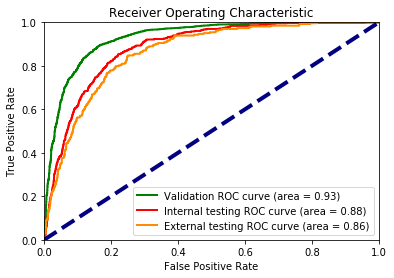

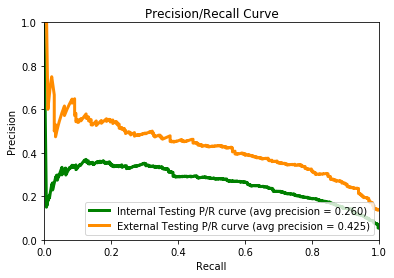

Precision at .9 recall: 0.785
F1 score:  0.84


In [11]:
plt.figure()
lw = 4
plt.plot(test_fpr, test_tpr, color='green', linewidth=2,
         lw=lw, label='Validation ROC curve (area = %0.2f)' % test_roc_auc)
plt.plot(ucsf_fpr, ucsf_tpr, color='red', linewidth=2,
         lw=lw, label='Internal testing ROC curve (area = %0.2f)' % ucsf_roc_auc)
plt.plot(valid_fpr, valid_tpr, color='darkorange', linewidth=2,
         lw=lw, label='External testing ROC curve (area = %0.2f)' % valid_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("../data/figures/roc%0.3f.png" % test_roc_auc)
plt.show()

eprecision, erecall, ethresholds = precision_recall_curve(test_labels, confs)
eavg_prec = average_precision_score(test_labels, confs)

iprecision, irecall, ithresholds = precision_recall_curve(ucsftest_labels, ucsfconfs)
iavg_prec = average_precision_score(ucsftest_labels, ucsfconfs)

plt.figure()
lw = 3
plt.plot(irecall, iprecision, color='green',
         lw=lw, label='Internal Testing P/R curve (avg precision = %0.3f)' % iavg_prec)
plt.plot(erecall, eprecision, color='darkorange',
         lw=lw, label='External Testing P/R curve (avg precision = %0.3f)' % eavg_prec)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall Curve')
plt.legend(loc="lower right")
plt.show()

r90_index = [i for i, r in enumerate(recall) if r > .9][-1]
p_at_r90 = precision[r90_index]
print('Precision at .9 recall: %0.3f' % p_at_r90)
f1 = [(2 * recall[i] * precision[i]) / (precision[i] + recall[i]) for i in range(len(recall))]
f1 = max(f1)
print('F1 score:  %0.2f' % f1)

In [ ]:
from end2end_process import EndToEndProcessor
from process_zsfg import get_reports_from_zsfg_csv
import itertools

corpora = ["../../Rnet_files/out_zsfg.csv"]
radlex_path = "../data/processed/radlex_replacements"
data = [get_reports_from_zsfg_csv(ip) for ip in corpora]
merged_data = list(set(list(itertools.chain.from_iterable(data))))
shuffle(merged_data)
merged_data = merged_data

e2e = EndToEndProcessor("../data/processed/clever_replacements", radlex="../data/processed/radlex_replacements")

report_pairs = []
while len(merged_data) > 0:
    labeled_proced = e2e.transform([merged_data[-1]])
    if len(labeled_proced) == 1:
        report_pairs.append((merged_data[-1], labeled_proced[0]))
    merged_data = merged_data[:-1]
shuffle(report_pairs)

mapped_report_strs = []
for mr in report_pairs:
    report_string = " ".join(mr[1][0]).replace("\n", " ")
    label = " __label__" + str(mr[1][1])
    mapped_report_strs.append((mr[0], report_string + label))

test = mapped_report_strs

test_og = [t[0] for t in test]
test_data = [t[1].split("__label__")[0] for t in test]
test_labels = [int(t[1].split("__label__")[1]) for t in test]

class Report():
    def __init__(self, original, data, label):
        self.original = original
        self.data = data
        self.label = label
        prediction = model.predict(data)
        self.conf = 1 - prediction[1][0] if prediction[0][0] == '__label__0' else prediction[1][0]
        self.confusion = (self.label - self.conf) ** 2

report_objs = []
for i in range(len(test)):
    report_objs.append(Report(test_og[i], test_data[i], test_labels[i]))
print(len(report_objs))

In [ ]:
pos_reps = [r for r in report_objs if r.label == 1 and r.conf < 0.8]
neg_reps = [r for r in report_objs if r.label == 0 and r.conf > 0.5]
sorted_pos = sorted(pos_reps, key=lambda x : x.confusion * -1)
sorted_neg = sorted(neg_reps, key=lambda x : x.confusion * -1)

In [ ]:
import csv

with open('../data/zsfg_false_pos.csv', 'w') as csvfile:
    field_names = ["Original Report", "Processed Report", "Ground Truth Label", "Predicted Label"]
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    writer.writeheader()
    
    for ro in sorted_neg:
        to_write = {}
        to_write["Original Report"] = ro.original
        to_write["Processed Report"] = ro.data
        to_write["Ground Truth Label"] = ro.label
        to_write["Predicted Label"] = ro.conf
        writer.writerow(to_write)

with open('../data/zsfg_false_neg.csv', 'w') as csvfile:
    field_names = ["Original Report", "Processed Report", "Ground Truth Label", "Predicted Label"]
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    writer.writeheader()
    
    for ro in sorted_pos:
        to_write = {}
        to_write["Original Report"] = ro.original
        to_write["Processed Report"] = ro.data
        to_write["Ground Truth Label"] = ro.label
        to_write["Predicted Label"] = ro.conf
        writer.writerow(to_write)
        
with open('../data/zsfg_all.csv', 'w') as csvfile:
    field_names = ["Original Report", "Processed Report", "Ground Truth Label", "Predicted Label"]
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    writer.writeheader()
    
    for ro in report_objs:
        to_write = {}
        to_write["Original Report"] = ro.original
        to_write["Processed Report"] = ro.data
        to_write["Ground Truth Label"] = ro.label
        to_write["Predicted Label"] = ro.conf
        writer.writerow(to_write)

In [ ]:
# Write test UCSF examples
from preprocessing import get_reports_from_csv


corpora = ["../../report_csvs/ucsf_test.csv"]
radlex_path = "../data/processed/radlex_replacements"
data = [get_reports_from_csv(ip) for ip in corpora]
merged_data = list(set(list(itertools.chain.from_iterable(data))))
shuffle(merged_data)
merged_data = merged_data

e2e = EndToEndProcessor("../data/processed/clever_replacements", radlex="../data/processed/radlex_replacements")

report_pairs = []
while len(merged_data) > 0:
    labeled_proced = e2e.transform([merged_data[-1]])
    if len(labeled_proced) == 1:
        report_pairs.append((merged_data[-1], labeled_proced[0]))
    merged_data = merged_data[:-1]
shuffle(report_pairs)

mapped_report_strs = []
for mr in report_pairs:
    report_string = " ".join(mr[1][0]).replace("\n", " ")
    label = " __label__" + str(mr[1][1])
    mapped_report_strs.append((mr[0], report_string + label))

test = mapped_report_strs

test_og = [t[0] for t in test]
test_data = [t[1].split("__label__")[0] for t in test]
test_labels = [int(t[1].split("__label__")[1]) for t in test]

report_objs = []
for i in range(len(test)):
    report_objs.append(Report(test_og[i], test_data[i], test_labels[i]))
print(len(report_objs))

In [ ]:
import csv

with open('../data/ucsf_test.csv', 'w') as csvfile:
    field_names = ["Original Report", "Processed Report", "Ground Truth Label", "Predicted Label"]
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    writer.writeheader()
    
    for ro in report_objs:
        to_write = {}
        to_write["Original Report"] = ro.original
        to_write["Processed Report"] = ro.data
        to_write["Ground Truth Label"] = ro.label
        to_write["Predicted Label"] = '%0.3f' % ro.conf
        writer.writerow(to_write)

In [ ]:
# Write all UCSF examples
from preprocessing import get_reports_from_csv


corpora = ["../../Rnet_files/positive_examples.csv", "../../Rnet_files/random_examples.csv", "../../Rnet_files/20170305-20170311RadReport.csv"]
radlex_path = "../data/processed/radlex_replacements"
data = [get_reports_from_csv(ip) for ip in corpora]
merged_data = list(set(list(itertools.chain.from_iterable(data))))
shuffle(merged_data)
merged_data = merged_data

e2e = EndToEndProcessor("../data/processed/clever_replacements", radlex="../data/processed/radlex_replacements")

report_pairs = []
while len(merged_data) > 0:
    labeled_proced = e2e.transform([merged_data[-1]])
    if len(labeled_proced) == 1:
        report_pairs.append((merged_data[-1], labeled_proced[0]))
    merged_data = merged_data[:-1]
shuffle(report_pairs)

mapped_report_strs = []
for mr in report_pairs:
    report_string = " ".join(mr[1][0]).replace("\n", " ")
    label = " __label__" + str(mr[1][1])
    mapped_report_strs.append((mr[0], report_string + label))

test = mapped_report_strs

test_og = [t[0] for t in test]
test_data = [t[1].split("__label__")[0] for t in test]
test_labels = [int(t[1].split("__label__")[1]) for t in test]

report_objs = []
for i in range(len(test)):
    report_objs.append(Report(test_og[i], test_data[i], test_labels[i]))
print(len(report_objs))

In [ ]:
with open('../data/ucsf_all.csv', 'w') as csvfile:
    field_names = ["Original Report", "Processed Report", "Ground Truth Label", "Predicted Label"]
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    writer.writeheader()
    
    for ro in report_objs:
        to_write = {}
        to_write["Original Report"] = ro.original
        to_write["Processed Report"] = ro.data
        to_write["Ground Truth Label"] = ro.label
        to_write["Predicted Label"] = '%0.3f' % ro.conf
        writer.writerow(to_write)